# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [1]:
from collections import defaultdict
from itertools import chain
from os import makedirs
from os.path import join
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.ensemble import GradientBoostingClassifier
from torch import nn
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm, trange

Будем использовать torchvision для работы с данными.

In [2]:
transform = transforms.Compose([transforms.ToTensor(), lambda x: (x * 2) - 1])

In [3]:
train_dataset = datasets.CIFAR10("./cifar", train=True, transform=transform, download=True)
val_dataset = datasets.CIFAR10("./cifar", train=False, transform=transform, download=True)
len(train_dataset), len(val_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [4]:
def denormalize_image(norm_image):
    return (norm_image + 1) / 2

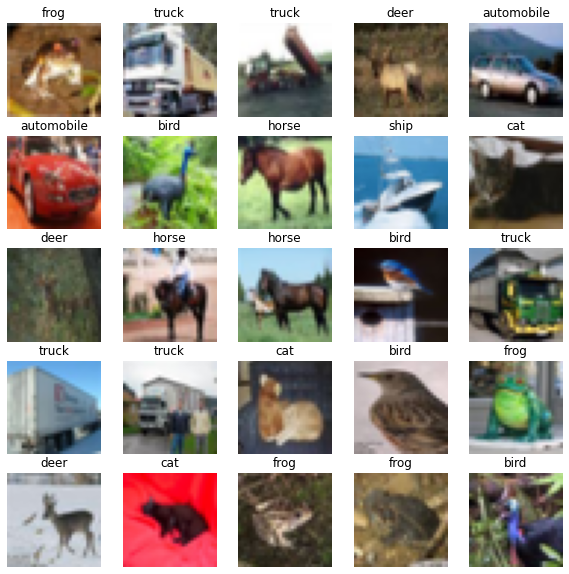

In [5]:
text_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis("off")
    plt.title(text_labels[label])
    if index == 24:
        break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [6]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
len(train_loader), len(val_loader)

(196, 40)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [8]:
class DenoisingBlock(nn.Module):
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        stride: int = 1,
        bias: bool = False,
        upsample: bool = False,
        lr_cf: float = 0.2
    ):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Conv2d(in_ch, out_ch, (3, 3), stride=stride, padding=1, bias=bias)
        self.norm = nn.BatchNorm2d(out_ch)
        self.act = nn.LeakyReLU(lr_cf)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)
        x = x + torch.randn_like(x) * 0.05
        x = self.dropout(x)
        return self.act(self.norm(self.conv(x)))

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int = 128, h_channels: int = 128):
        super().__init__()
        self.blocks = nn.Sequential(
            DenoisingBlock(3, h_channels, stride=2),
            DenoisingBlock(h_channels, h_channels, stride=2),
            DenoisingBlock(h_channels, h_channels, stride=2),
            DenoisingBlock(h_channels, h_channels, stride=2),
            DenoisingBlock(h_channels, h_channels, stride=1).conv,
        )
        self.linear = nn.Linear(h_channels * 2 * 2, latent_dim)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        convolved = self.blocks(images)
        return self.linear(convolved.view(images.shape[0], -1))

In [10]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert encoder(noise).view(-1).shape[0] < 1*3*32*32

In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dim: int = 128, h_channels: int = 128):
        super().__init__()
        self.linear = nn.Linear(latent_dim, h_channels * 2 * 2)
        self.h_channels = h_channels
        self.blocks = nn.Sequential(
            DenoisingBlock(h_channels, h_channels, upsample=True),
            DenoisingBlock(h_channels, h_channels, upsample=True),
            DenoisingBlock(h_channels, h_channels, upsample=True),
            DenoisingBlock(h_channels, h_channels, upsample=True),
            DenoisingBlock(h_channels, 3).conv,
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        sized = self.linear(images)
        sized = sized.view(-1, self.h_channels, 2, 2)
        return self.blocks(sized)

In [12]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32)

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [13]:
def classification_score(m_encoder, t_dataset, v_dataset, cur_device):
    m_encoder.eval()
    torch.manual_seed(0)
    t_dataset = Subset(t_dataset, torch.randperm(len(t_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(t_dataset):
        image = image.to(cur_device)
        with torch.no_grad():
            emb = m_encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=10, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(v_dataset):
        image = image.to(cur_device)
        with torch.no_grad():
            emb = m_encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [14]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')


      Iter       Train Loss   Remaining Time 
         1           2.2288           23.69s
         2           2.1741           21.35s
         3           2.1210           18.50s
         4           2.0645           15.66s
         5           2.0100           13.01s
         6           1.9647           10.42s
         7           1.9236            7.78s
         8           1.8800            5.18s
         9           1.8405            2.60s
        10           1.8053            0.00s


0.1377

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
encoder = encoder.to(device)
decoder = decoder.to(device)

In [17]:
params = chain(encoder.parameters(), decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [18]:
def train(loader, optimizer, m_encoder, m_decoder, cur_device):
    m_encoder.train()
    m_decoder.train()
    losses = []

    loader_bar = tqdm(loader, leave=False, desc="Training")
    postfix = {}
    for b_images, _ in loader_bar:
        b_images = b_images.to(cur_device)
        noise = torch.randn_like(b_images, requires_grad=False) * 0.1
        noised_images = torch.clamp(b_images + noise, -1, 1)

        embeddings = m_encoder(noised_images)
        rec_images = m_decoder(embeddings)
        cur_loss = F.mse_loss(b_images, rec_images)

        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()

        losses.append(cur_loss.item())
        postfix["loss"] = losses[-1]
        loader_bar.set_postfix(postfix)

    loader_bar.close()
    return sum(losses) / len(losses)

In [19]:
temp_dataloader = DataLoader(Subset(train_dataset, [0]), batch_size=1)
loss = train(temp_dataloader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

0.3168874680995941

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [20]:
def eval(loader, m_encoder, m_decoder, cur_device):
    m_encoder.eval()
    m_decoder.eval()
    losses = []
    for b_images, _ in tqdm(loader, leave=False, desc="Evaluation"):
        b_images = b_images.to(cur_device)
        with torch.no_grad():
            embeddings = m_encoder(b_images)
            rec_images = m_decoder(embeddings)
            cur_loss = F.mse_loss(b_images, rec_images)
        losses.append(cur_loss.item())
    return sum(losses) / len(losses)

In [21]:
temp_dataloader = DataLoader(Subset(train_dataset, [0]), batch_size=1)
loss = eval(temp_dataloader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

0.18946921825408936

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [22]:
def full_train(
    cur_device: torch.device,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    n_epochs: int = 15,
    lr: float = 1e-3,
):
    m_encoder = Encoder().to(cur_device)
    m_decoder = Decoder().to(cur_device)
    optimizer = torch.optim.AdamW(chain(m_encoder.parameters(), m_decoder.parameters()), lr=lr)
    train_loss = []
    val_loss = []

    postfix = {}
    epoch_bar = trange(n_epochs, desc="Epochs", postfix=postfix)
    for e in epoch_bar:
        e_train_loss = train(train_dataloader, optimizer, m_encoder, m_decoder, cur_device)
        train_loss.append(e_train_loss)

        e_val_loss = eval(val_dataloader, m_encoder, m_decoder, cur_device)
        val_loss.append(e_val_loss)

        postfix["Train MSE loss"] = e_train_loss
        postfix["Validation MSE loss"] = e_val_loss
        epoch_bar.set_postfix(postfix)

    epoch_bar.close()

    plt.plot(train_loss, label="train")
    plt.plot(val_loss, label="val")
    plt.legend()
    plt.title("MSE Loss")
    plt.show()

    return m_encoder, m_decoder

In [23]:
# encoder, decoder = full_train(device, train_loader, val_loader, n_epochs=15)

In [24]:
# makedirs("weights", exist_ok=True)
# torch.save(encoder.state_dict(), join("weights", "encoder.pth"))
# torch.save(decoder.state_dict(), join("weights", "decoder.pth"))

In [25]:
makedirs("weights", exist_ok=True)
urlretrieve("https://github.com/SpirinEgor/HSE.gans/raw/master/homework_1/weights/encoder.pth", join("weights", "encoder.pth"))
urlretrieve("https://github.com/SpirinEgor/HSE.gans/raw/master/homework_1/weights/decoder.pth", join("weights", "decoder.pth"))

('weights/decoder.pth', <http.client.HTTPMessage at 0x7fddd06e0af0>)

In [26]:
encoder = Encoder().to(device)
encoder.load_state_dict(torch.load(join("weights", "encoder.pth"), map_location=device))
decoder = Decoder().to(device)
decoder.load_state_dict(torch.load(join("weights", "decoder.pth"), map_location=device))

<All keys matched successfully>

In [27]:
score = classification_score(encoder, train_dataset, val_dataset, device)
assert score > 0.34


      Iter       Train Loss   Remaining Time 
         1           2.1277           22.98s
         2           1.9979           20.19s
         3           1.8937           17.77s
         4           1.7993           15.25s
         5           1.7172           12.72s
         6           1.6457           10.19s
         7           1.5828            7.60s
         8           1.5184            5.04s
         9           1.4601            2.51s
        10           1.4087            0.00s


In [28]:
score

0.3445

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

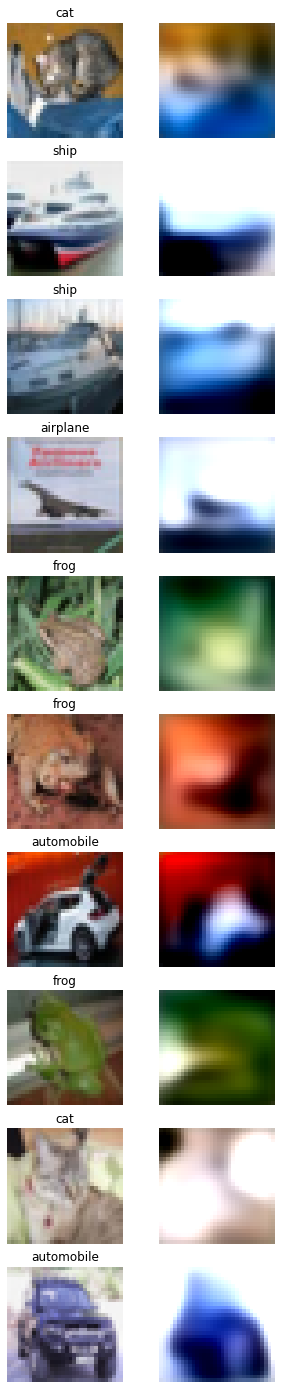

In [29]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_dataset):
    plt.subplot(10, 2, index * 2 + 1)
    plt.imshow(denormalize_image(image).permute(1, 2, 0))
    plt.axis("off")
    plt.title(text_labels[label])
    plt.subplot(10, 2, index * 2 + 2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image.unsqueeze(0))
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis("off")
    if index == 9:
        break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [30]:
def get_representations(dataloader, m_encoder, cur_device):
    m_encoder.eval()
    representations = defaultdict(list)
    for b_images, b_labels in tqdm(dataloader):
        b_images = b_images.to(cur_device)
        with torch.no_grad():
            embeddings = m_encoder(b_images)
        for emb, label in zip(embeddings, b_labels):
            representations[label.item()].append(emb.detach())
    return representations

In [31]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [32]:
def calculate_fid(repr1: torch.Tensor, repr2: torch.Tensor) -> float:
    mu_r = repr1.mean(0)
    mu_g = repr2.mean(0)
    term1 = np.linalg.norm(mu_r - mu_g)

    sigma_r = np.cov(repr1)
    sigma_g = np.cov(repr2)
    term2 = np.trace(sigma_r + sigma_g - 2 * np.sqrt(sigma_g * sigma_r))
    return term1 + term2

In [33]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

/var/folders/vw/cn7lrm9j7bvd1rdyfymttkrh0000kt/T/ipykernel_17786/3661175303.py:8: RuntimeWarning: invalid value encountered in sqrt
  term2 = np.trace(sigma_r + sigma_g - 2 * np.sqrt(sigma_g * sigma_r))


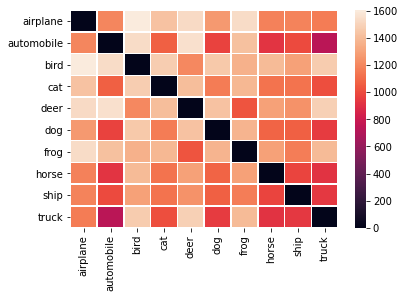

In [34]:
sns.heatmap(heatmap, linewidth=0.5, xticklabels=text_labels, yticklabels=text_labels)
plt.show()